# EDA 1 - Exploração da Coletânea Principal de Hinos da ICM

Nessa exploração de dados, o objetivo é obter informações sobre a Coletânea de Hinos da Igreja Cristã Maranata (ICM) - Edição 2018.

O objetivo é fornecer uma visão geral dos hinos, suas categorias, e aspectos relevantes para pesquisadores, músicos e interessados na música da ICM.

Como descrito na própria coletânea:
> Os hinos e louvores, editados nesta Coletânea, englobam partes de outras edições já publicadas que expressam gratidão, adoração e louvor ao nosso Deus, entoados em todas épocas vividas pela Igreja Fiel, momento também comemorado pela Igreja Cristã Maranata em seus cinquenta anos de existência. 

## Origem dos dados

A extração de dados para construção da base tem por primeira origem os slides oficiais disponibilizados pelo [Departamento de Louvor da ICM](https://louvoricm.org.br/downloads/). Outros processos manuais foram necessários, e estão disponíveis neste repositório.

## Organização

Este é o primeiro de oito notebooks, cada um aprofundando diferentes aspectos da análise exploratória dos dados.

---
**Conteúdo do notebook:**
- Introdução e contexto dos dados
- Carregamento dos dados da coletânea
- Limpeza e preparação dos dados
- Análise das categorias de hinos
- Visualização dos resultados
- Exportação dos dados tratados

---

**A seguir:** Importação das bibliotecas e conexão com o banco de dados SQLite que contém os hinos extraídos da coletânea.

In [1]:
# --- Conexão com o banco de dados SQLite ---
from sqlalchemy import create_engine

# Cria engine para acessar o banco de dados local (assets/database.db)
engine = create_engine("sqlite:///../assets/database.db")
connection = engine.connect()

---

**A seguir:** Consulta SQL para extrair os dados dos hinos, incluindo número, nome, texto, categoria e descrição da categoria. Os dados são carregados em um DataFrame para análise.

In [2]:
# --- Consulta SQL: Seleção dos hinos da coletânea principal ---
import pandas as pd

# Monta a query para buscar hinos e suas categorias
sql_query = """
select
    numero,
    nome,
    texto,
    texto_limpo,
    categoria_id,
    c.descricao as categoria
from 
    hino
    left join categoria c on c.id = categoria_id
where
    coletanea_id = 1 -- hinos da coletanea padrao
"""

# Executa a consulta e carrega em um DataFrame
hinos_analise = pd.read_sql_query(sql_query, connection)

# Exibe os primeiros registros para conferência
hinos_analise.head()

,numero,nome,texto,texto_limpo,categoria_id,categoria
0,01,O SANGUE DE JESUS TEM PODER,"O SANGUE DE JESUS TEM PODER,\nPODER QUE A MIM ...","O SANGUE DE JESUS TEM PODER, PODER QUE A MIM P...",1,CLAMOR
1,02,O SANGUE DE JESUS TEM PODER PARA SALVAR,O SANGUE DE JESUS TEM PODER (2x)\nO SANGUE DE ...,"O SANGUE DE JESUS TEM PODER O SANGUE DE JESUS,...",1,CLAMOR
2,03,CLAMO A TI,"CLAMO A TI, Ó MEU SENHOR,\nCLAMO A TI, MEU SAL...","CLAMO A TI, Ó MEU SENHOR, CLAMO A TI, MEU SALV...",1,CLAMOR
3,04,QUANDO TE PROSTRARES,"QUANDO TE PROSTRARES DIANTE DE DEUS,\nLEMBRA Q...","QUANDO TE PROSTRARES DIANTE DE DEUS, LEMBRA QU...",1,CLAMOR
4,05,CLAMANDO ESTOU,"CLAMANDO ESTOU, Ó MEU JESUS,\nPOR TEU SANGUE R...","CLAMANDO ESTOU, Ó MEU JESUS, POR TEU SANGUE RE...",1,CLAMOR


---

**A seguir:** Limpeza dos dados: ajusta o campo de número dos hinos, converte para inteiro, renomeia colunas e ordena os hinos para facilitar a análise.

In [3]:
# --- Limpeza e organização dos dados ---
# Corrige valores nulos e converte número para inteiro
hinos_analise.loc[hinos_analise["numero"] == "null", "numero"] = 0
hinos_analise["numero_int"] = hinos_analise["numero"].astype(int)

# Remove coluna antiga, renomeia e ordena
hinos_analise = (
    hinos_analise.drop(columns=["numero"])
    .rename(columns={"numero_int": "numero"})
    .sort_values("numero")
)

# Exibe os dados organizados
hinos_analise.head()

,nome,texto,texto_limpo,categoria_id,categoria,numero
794,AQUILO QUE FUI NÃO SOU MAIS,"AQUILO QUE FUI NÃO SOU MAIS,\nNEM SOU TUDO O Q...","AQUILO QUE FUI NÃO SOU MAIS, NEM SOU TUDO O QU...",1,CLAMOR,0
0,O SANGUE DE JESUS TEM PODER,"O SANGUE DE JESUS TEM PODER,\nPODER QUE A MIM ...","O SANGUE DE JESUS TEM PODER, PODER QUE A MIM P...",1,CLAMOR,1
1,O SANGUE DE JESUS TEM PODER PARA SALVAR,O SANGUE DE JESUS TEM PODER (2x)\nO SANGUE DE ...,"O SANGUE DE JESUS TEM PODER O SANGUE DE JESUS,...",1,CLAMOR,2
2,CLAMO A TI,"CLAMO A TI, Ó MEU SENHOR,\nCLAMO A TI, MEU SAL...","CLAMO A TI, Ó MEU SENHOR, CLAMO A TI, MEU SALV...",1,CLAMOR,3
3,QUANDO TE PROSTRARES,"QUANDO TE PROSTRARES DIANTE DE DEUS,\nLEMBRA Q...","QUANDO TE PROSTRARES DIANTE DE DEUS, LEMBRA QU...",1,CLAMOR,4


---

**A seguir:** Exportação dos dados tratados para um arquivo pickle, permitindo reutilização em outras análises ou notebooks.

In [4]:
# --- Salvando o DataFrame para uso posterior ---
from pathlib import Path

assets_folder = Path("../assets")
hinos_analise.to_pickle(assets_folder / "hinos_analise.pkl")

795 louvores ao todo.

## Categorias

---

**A seguir:** Agrupamento dos hinos por categoria, contabilizando a quantidade de hinos em cada uma e criando abreviações para facilitar a visualização.

In [5]:
# --- Contagem de hinos por categoria ---
categorias_count = (
    hinos_analise[["categoria_id", "categoria", "numero"]]
    .groupby(["categoria_id", "categoria"])
    .count()
    .reset_index()
    .rename(columns={"numero": "contagem"})
)

# Cria abreviação para categorias longas
categorias_count["categoria_abr"] = categorias_count["categoria"].apply(
    lambda x: x[:13] + "..." if len(x) > 15 else x
)

# Exibe o resultado
categorias_count

,categoria_id,categoria,contagem,categoria_abr
0,1,CLAMOR,57,CLAMOR
1,2,INVOCAÇÃO E COMUNHÃO,40,INVOCAÇÃO E C...
2,3,DEDICAÇÃO,104,DEDICAÇÃO
3,4,"MORTE, RESSURREIÇÃO E SALVAÇÃO",94,"MORTE, RESSUR..."
4,5,CONSOLO E ENCORAJAMENTO,91,CONSOLO E ENC...
5,6,SANTIFICAÇÃO E DERRAMAMENTO DO ESPÍRITO SANTO,92,SANTIFICAÇÃO ...
6,7,VOLTA DE JESUS E ETERNIDADE,94,VOLTA DE JESU...
7,8,LOUVOR,78,LOUVOR
8,9,SALMOS DE LOUVOR,16,SALMOS DE LOU...
9,10,GRUPO DE LOUVOR,65,GRUPO DE LOUVOR


---

**A seguir:** Visualização gráfica da distribuição dos hinos por categoria, utilizando Seaborn e Matplotlib para criar um gráfico de barras.

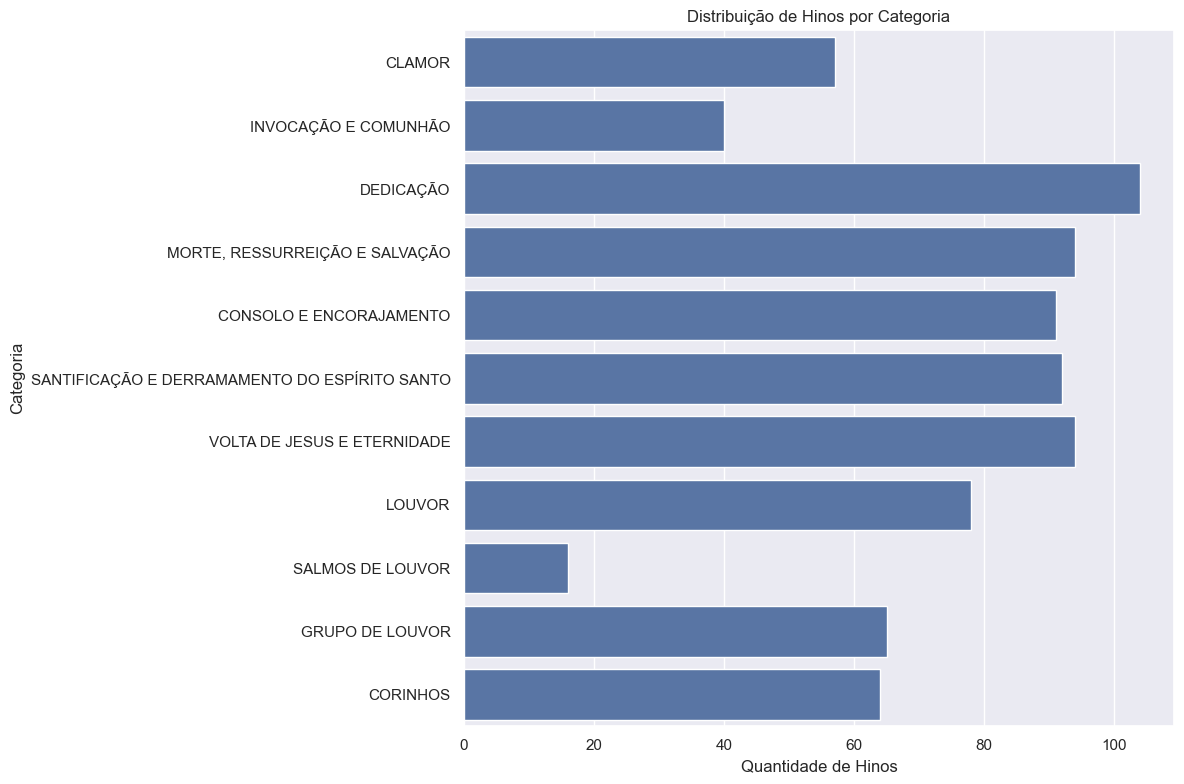

In [6]:
# --- Visualização da distribuição de hinos por categoria ---
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="darkgrid")

# Cria gráfico de barras para visualizar a contagem de hinos por categoria
fig, ax = plt.subplots(figsize=(12, 8))
sns.barplot(x="contagem", y="categoria", data=categorias_count, ax=ax)
plt.title("Distribuição de Hinos por Categoria")
plt.xlabel("Quantidade de Hinos")
plt.ylabel("Categoria")
plt.tight_layout()
plt.show()

---

**Fim do notebook:** Aqui finalizamos a análise exploratória, com os dados prontos para visualização e exportação. 